# Packages Overview

## spekpy
[Overview](https://bitbucket.org/spekpy/spekpy_release/wiki/Home)

[Glossary](https://bitbucket.org/spekpy/spekpy_release/wiki/Function%20glossary)

## xraydb
[Overview](https://xraypy.github.io/XrayDB/)


In [1]:
from spectrumEstimations import SpekEstimations

import numpy as np
import matplotlib.pyplot as plt
import spekpy as sp
import xraydb

In [2]:
## Parameters
kvp = 100. # Tube potential [kV] 
theta = 10.5 # Anode angle [deg.]
dx = 2. # Increment in lateral direction (= 0.5 in book figures) [cm]
z = 62.56 # Source-to-dector distance [cm]
dk = 0.5  # Width of energy bin [keV] 

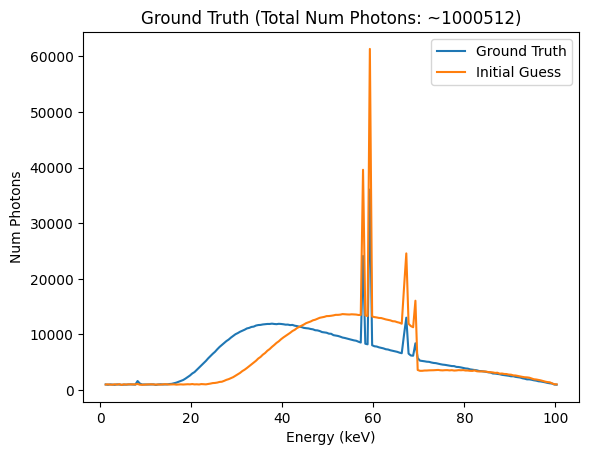

In [3]:
## Load Spectrum
spectrum = sp.Spek(th=theta,kvp=kvp,physics="kqp",char=True,obli=False)
#spectrum.filter('Al',3.9)
spectrum.multi_filter([('C',1.94), ('Al',0.19), ('Cu',0.07)])
Es,spectra = spectrum.get_spectrum(addend=True)

numPhotons = np.random.poisson(10**6)
groundTruth = spectra/np.sum(spectra)*numPhotons + np.random.poisson(1000,len(Es)).astype(int)
groundTruth[groundTruth==0] = 1


## Get initial W guess
initialGuessObject = sp.Spek(th=theta,kvp=kvp,physics="kqp",char=True,obli=False)
initialGuessObject.multi_filter([('W',0.08)])
_, initialGuess = initialGuessObject.get_spectrum(addend=True)
initialGuess = initialGuess/np.sum(initialGuess)*numPhotons + np.random.poisson(1000,len(Es)).astype(int)
initialGuess[initialGuess==0] = 1


plt.figure()
plt.plot(Es, groundTruth, label="Ground Truth")
plt.plot(Es,initialGuess,label="Initial Guess",linestyle="-")
plt.title("Ground Truth (Total Num Photons: ~{})".format(numPhotons))
plt.ylabel("Num Photons")
plt.xlabel("Energy (keV)")
plt.legend()

/Users/ktmath/Desktop/Fall23/BENG280A/project1/code/BENG280ACode/spectrumEstimations.py:84: RuntimeWarning: divide by zero encountered in divide
  G = np.divide(self.Ws,self.summedOverMeasurements) ## numEnergyBins x1
/Users/ktmath/Desktop/Fall23/BENG280A/project1/code/BENG280ACode/spectrumEstimations.py:86: RuntimeWarning: invalid value encountered in divide
  R = np.transpose(np.sum([self.A[i,:]*self.transmissionMeasurements[i]/H[i] for i in range(self.numMeasurements)],axis=0)) ## numEnergyBins x 1


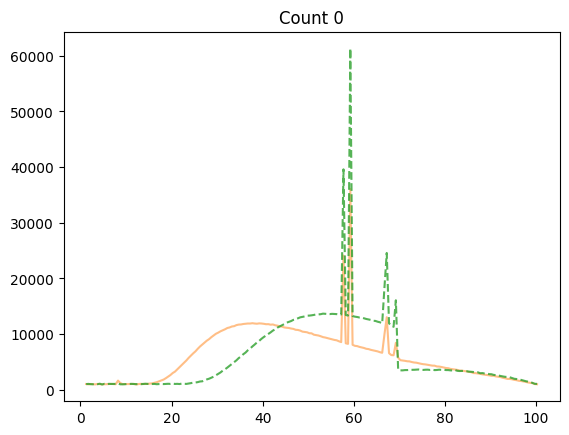

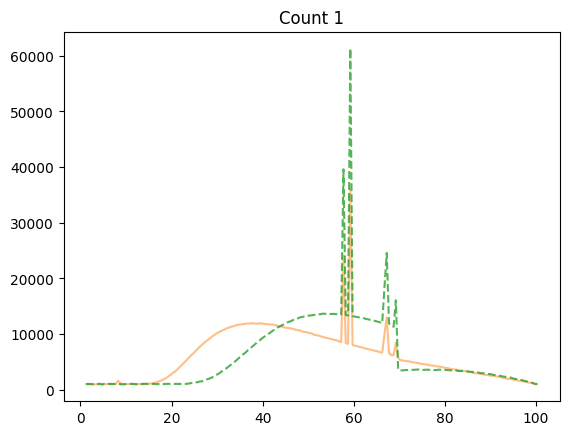

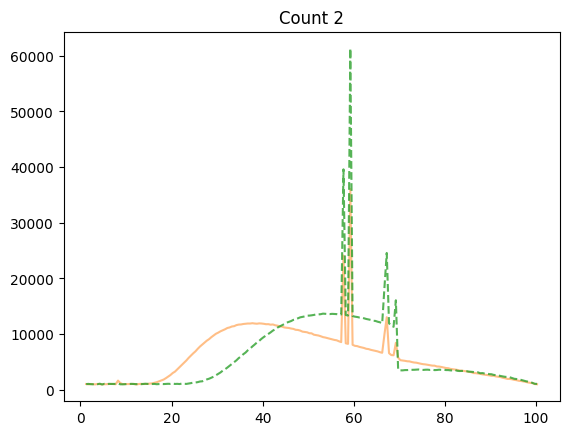

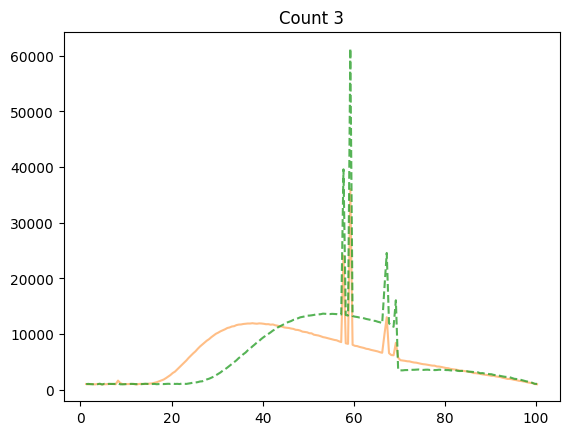

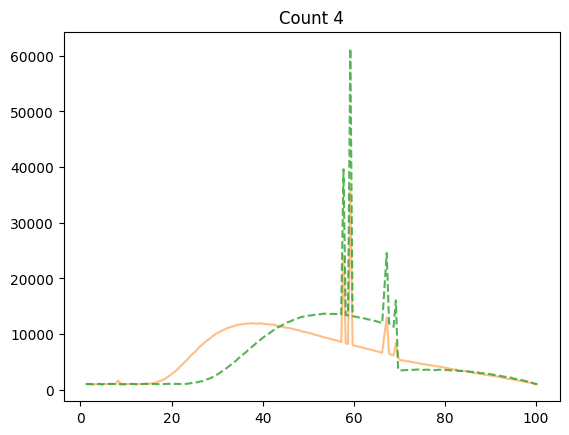

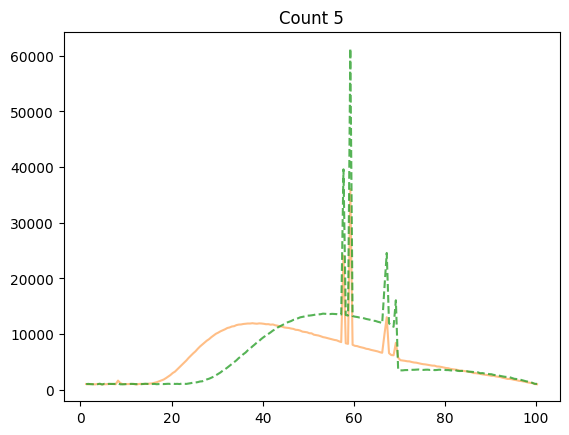

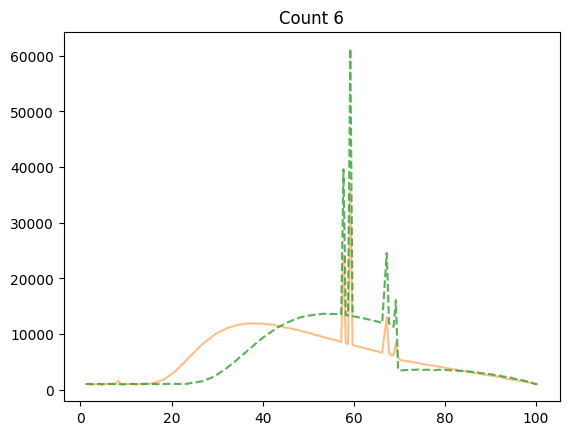

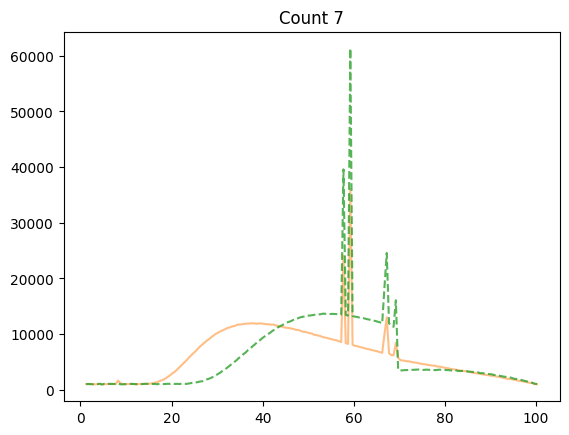

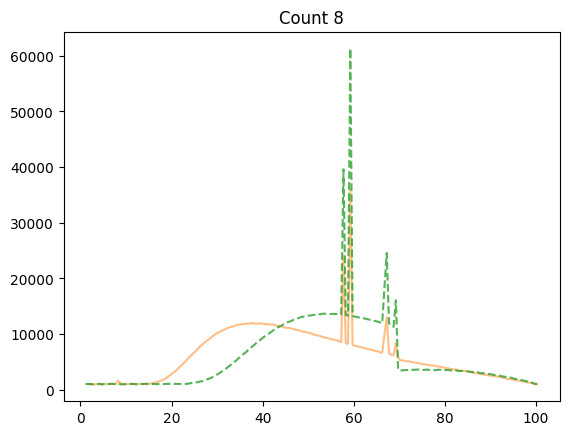

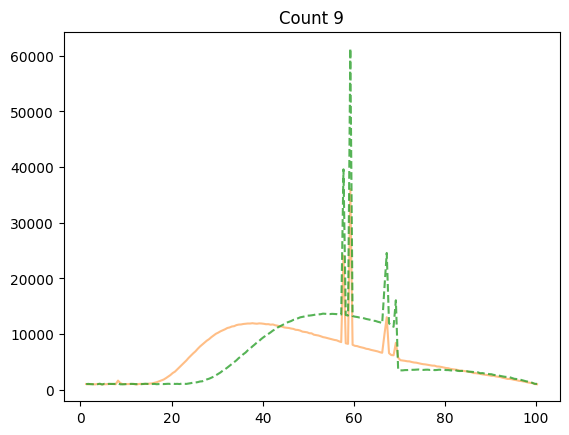

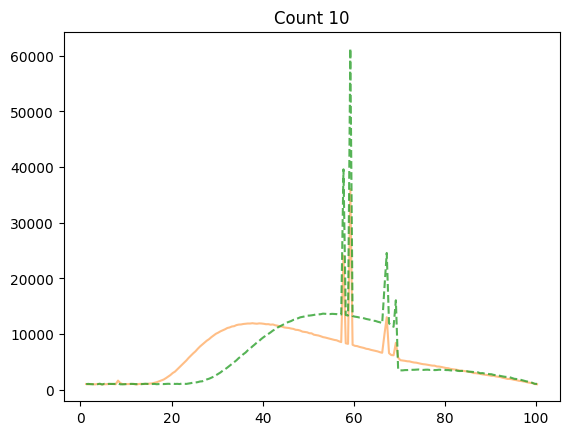

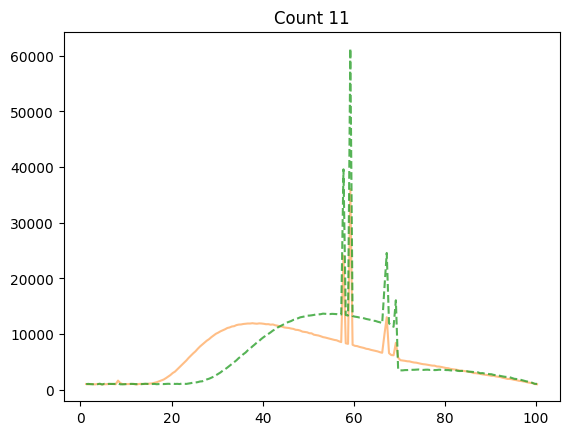

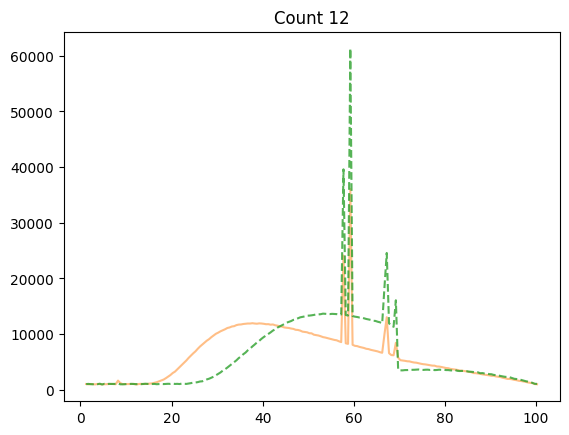

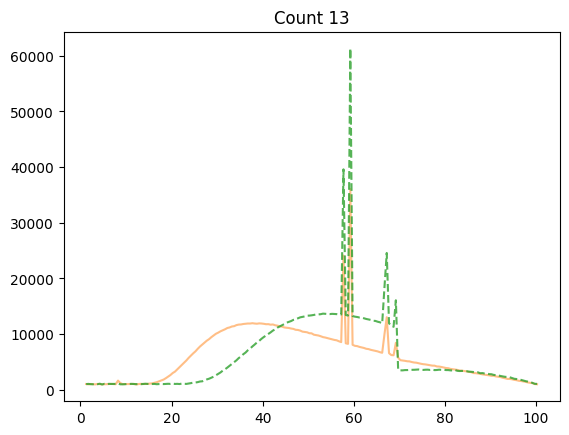

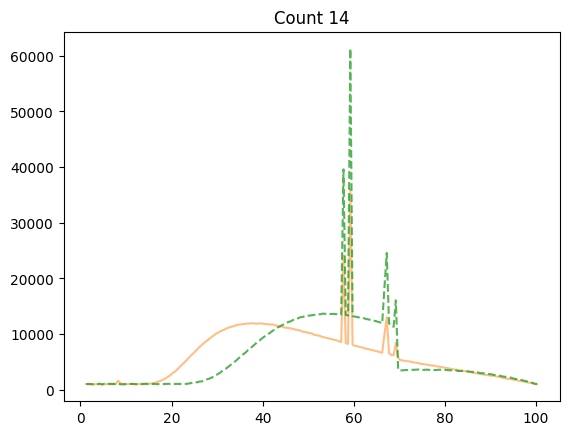

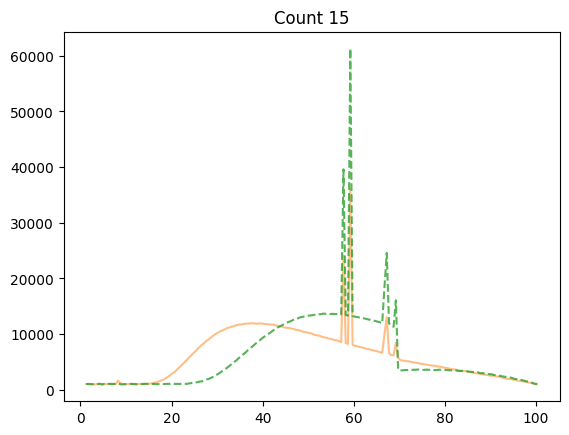

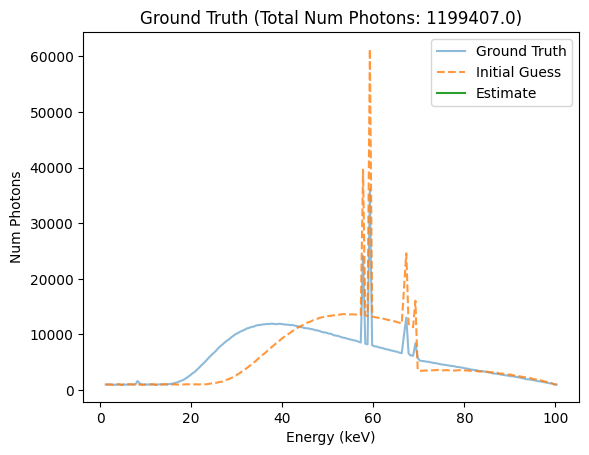

In [4]:
## Prepare Simulation 
phantomLengths = np.linspace(0.136,2.54,16,endpoint=True)
spectrum = Es, groundTruth

## Preparing Mu values
materials  = [('Al',2.7)]
materialMus =np.zeros((len(materials), len(Es)))
for i in range(len(materials)):
    materialMus = xraydb.material_mu(materials[i][0],Es,density=materials[i][1]) #code expects 1/cm 



## Estimate Spectrum
estimationObj = SpekEstimations(materialMus,phantomLengths,initialGuess,spectrum)
estimateWs = estimationObj.getSpectrum()
estimationObj.plotSpectrum()


In [5]:
estimateWs

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na